# Lab 1
Antoine Sutter

First we import all the dependencies we will need.

In [61]:
import os
import numpy as np
from skimage import metrics
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

Then we prepare the images before we can process them. Images were randomly picked on Pexel, a free stock image service. The original images are in the `images` directory. They are then scaled down to 256, 512, 1000 and 2000 before being distorted.

In [62]:
images = [
    ("pexels-icsa.jpg", 256),
    ("pexels-jibarofoto.jpg", 512),
    ("pexels-lecreusois.jpg", 1024),
    ("pexels-olly.jpg", 2048),
]

image_folder = 'images'
resized_folder = 'resized_images'
distorted_folder = 'distorted_images'

os.makedirs(resized_folder, exist_ok=True)
os.makedirs(distorted_folder, exist_ok=True)


To prepare the images, we will do 4 things:

* scale the image to its correct size
* convert the image to gray scale
* apply a gaussian blur
* apply some jpeg compression
    
Note: I hate the API of the PIL package, some methods mutate the original image, others don't. This is why I reopen the images at the end.

In [63]:
def prepare_image(image: tuple[str, int], blur_radius=0, jpeg_quality=100) -> tuple[Image, Image]:
    filename, size = image
    file_path = os.path.join(image_folder, filename)
    resized_filepath = os.path.join(resized_folder, filename)
    distorted_filepath = os.path.join(distorted_folder, filename)

    with (Image.open(file_path) as img):
        img.thumbnail((size, size))
        img = img.convert('L')
        img.save(resized_filepath, format="JPEG", quality=100, optimize=False)

        # Now distort the image
        img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        img.save(distorted_filepath, format="JPEG", quality=jpeg_quality, optimize=False)

    # Reopen the image to ensure we have fresh data
    return (
        np.array(Image.open(resized_filepath)),
        np.array(Image.open(distorted_filepath))
    )


def prepare_images(sources: list[tuple[str, int]], blur_radius=0, jpeg_quality=100) -> list[tuple[Image, Image]]:
    return [prepare_image(image, blur_radius=blur_radius, jpeg_quality=jpeg_quality) for image in sources]

We can now prepare the images with a blur of 10 and a jpeg quality of 10

In [65]:
image_data = prepare_images(images, blur_radius=5, jpeg_quality=80)

To evaluate the images, I will use the `skimage` package. This code does not implement the bonus LPIPS method.  

## MSE RESULTS

The higher the MSE, the lesser the quality of the tested image is compared to the original. We can see that despite the same blur and jpeg compression for all image sizes, the smaller the image is the more affected it is by the distortions. For reference, an MSE of 0 would mean the images are similar.

## PSNR

Unlike MSE, the higher the PSNR, the higher the quality of the tested image is compared to the original. Therefore we can see the bar charts is increasing with the image size, giving us a similar conclusion than with MSE that lower resolution images are more affected by the distorions.

## SSMI

Similarly to PSNR, the higher the SSMI, the higher the quality of the tested image is compared to the original. In this case, the value is normalized between 0 and 1 with 1 meaning a perfect quality. In fact, if you call `metrics.structural_similarity` with the same image twice, you'll get 1 out.


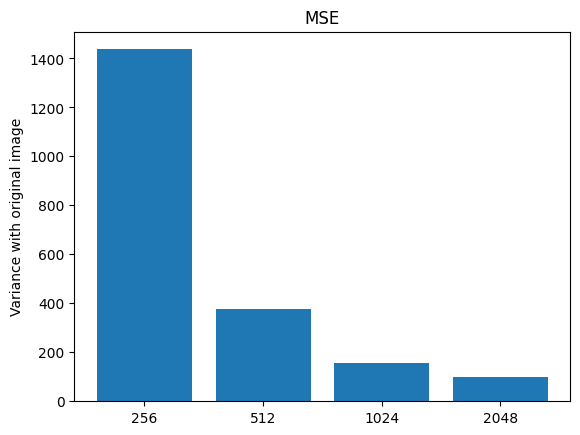

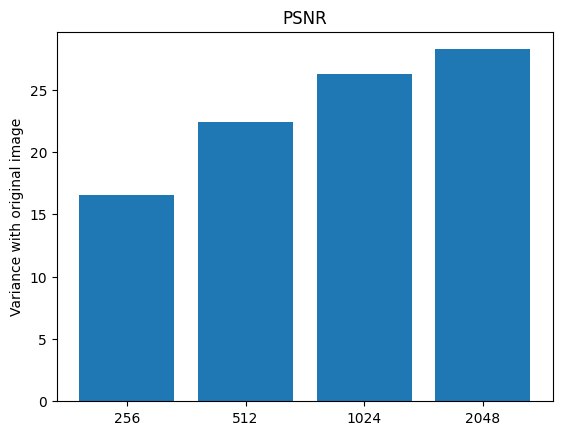

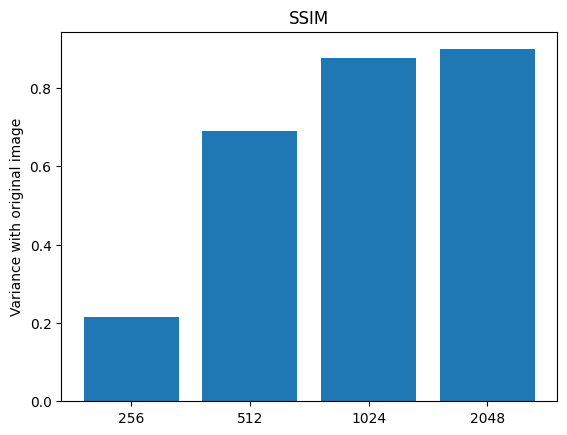

In [67]:
axis = [f"{size}" for name, size in images]

metric = [
    ("MSE", metrics.mean_squared_error),
    ("PSNR", metrics.peak_signal_noise_ratio),
    ("SSIM", metrics.structural_similarity),
]

for metric_name, metric_function in metric:
    data = [metric_function(a, b) for a, b in image_data]

    fig, ax = plt.subplots()

    ax.bar(axis, data)
    ax.set_ylabel('Variance with original image')
    ax.set_title(metric_name)

    plt.show()
